##### Scope
Predicting credit scores in a multi-class problem.

# 1. Multiclass Logistic Regression


##### 1.1. Fitting a multiclass logistic regression with three credit scores


In [1]:
import pandas as pd
import numpy as np

credit_df = pd.read_csv("../Data/credit_train_clean.csv").drop(["Name", "SSN"], axis=1)

credit_df.head()

,ID,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


In [2]:
credit_df["Credit_Score"].value_counts()

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split

features = [
    "Age",
    "Month",
    "Annual_Income",
    "Num_Bank_Accounts",
    "Changed_Credit_Limit",
    "Num_Credit_Card",
    "Credit_History_Age", 
    "Payment_of_Min_Amount", 
    "Monthly_Balance", 
    "Payment_Behaviour",
    "Num_Credit_Inquiries",
    "Outstanding_Debt",
    "Credit_Mix",
    "Total_EMI_per_month"
]

X = pd.get_dummies(credit_df[features], dtype="int", drop_first=True)
y = credit_df["Credit_Score"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

##### 1.2. Standardization and tuning

In [4]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': np.linspace(0.05,0.1,10),    
    'penalty': ['l1', 'l2']
}

gridsearch = GridSearchCV(LogisticRegression(solver='saga', max_iter=1000), parameters)

gridsearch.fit(X_train_std, y_train)

gridsearch.best_params_

{'C': 0.07777777777777778, 'penalty': 'l1'}

##### 1.3. Model fitting

In [6]:
logreg = LogisticRegression(C=gridsearch.best_params_['C'], 
                            penalty=gridsearch.best_params_['penalty'], 
                            solver='saga', 
                            max_iter=1000)

lr = logreg.fit(X_train_std, y_train)

print(f"Train Acc.: {lr.score(X_train_std, y_train)}")
print(f"Test Acc.: {lr.score(X_test_std, y_test)}")

Train Acc.: 0.6475875
Test Acc.: 0.64285


In [7]:
list(lr.classes_)

['Good', 'Poor', 'Standard']

##### 1.4. Confusion matrix and coefficients measuring impact

In [8]:
def show_confusion_matrix(classes,X_predict,y_train):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    confussion = confusion_matrix(y_train, X_predict)
    sns.heatmap(
        confussion,
        cmap="Blues",
        annot=True,
        fmt='g',
        square=True,
        xticklabels=list(classes),
        yticklabels=list(classes)
    ).set(
        xlabel='Actual',
        ylabel='Predicted',
        title='Confusion matrix'
    );

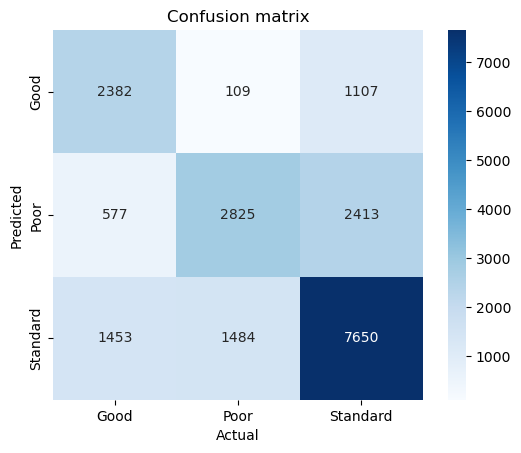

In [9]:
show_confusion_matrix(lr.classes_,lr.predict(X_test_std),y_test)

In [10]:
coefficinets_list = pd.DataFrame({'Parameter': X_test.columns, 'Coef.': list(map(np.exp, lr.coef_[0]))})
coefficinets_list.sort_values(by='Coef.').head(20)

,Parameter,Coef.
5,Num_Credit_Card,0.657661
17,Payment_Behaviour_Low_spent_Small_value_payments,0.850136
12,Payment_of_Min_Amount_Yes,0.889052
7,Monthly_Balance,0.890824
9,Outstanding_Debt,0.928622
16,Payment_Behaviour_Low_spent_Medium_value_payments,0.933096
15,Payment_Behaviour_Low_spent_Large_value_payments,0.945422
14,Payment_Behaviour_High_spent_Small_value_payments,0.968674
13,Payment_Behaviour_High_spent_Medium_value_paym...,0.989545
2,Annual_Income,1.000000
